In [3]:
%matplotlib inline

In [4]:
import  os
import  sys
import  glob
import  mpld3

In [5]:
import  pdfkit
import  fitsio
import  redrock
import  datetime
import  redrock.templates

import  pandas                  as      pd
import  pylab                   as      pl
import  numpy                   as      np
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits
import  matplotlib.pyplot       as      plt
import  astropy.io.fits         as      fits

from    astropy.table           import  Table, join, vstack, unique
from    astropy.coordinates     import  SkyCoord
from    astropy                 import  units as u
from    desitarget.cmx          import  cmx_targetmask
from    desitarget              import  targetmask
from    desispec.interpolation  import  resample_flux
from    desispec.resolution     import  Resolution
from    desispec.specscore      import  compute_frame_scores
from    collections             import  OrderedDict
from    mpl_toolkits.axes_grid1 import  make_axes_locatable
from    itertools               import  combinations
from    desisurvey.utils        import  get_date

In [6]:
##  DR7 cutouts
import  requests

from    PIL                     import  Image
from    io                      import  BytesIO

In [7]:
# Prospect
sys.path.append("/global/homes/m/mjwilson/BGS/MINISV/prospect/py/")

import desispec
import prospect

from   prospect                import utils_specviewer, plotframes

/global/homes/m/mjwilson/BGS/MINISV/prospect/py/prospect/utils_specviewer.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/conda/lib/python3.6/site-

In [8]:
plt.rcParams['figure.figsize'] = [10, 10]

In [9]:
# mpld3.enable_notebook()

#  Understand spurious flux lines in BGS spectra

e.g.  those at 4358. Angstrom here: 

https://portal.nersc.gov/project/desi/users/mjwilson/MINISV/specviewer_70500_20200303_NEXP1-52932_0.html

In [10]:
# /global/homes/m/mjwilson/BGS/MINISV/zhou
version = 'v2'
root    = '/global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225/'

In [11]:
expid   = 52090

In [12]:
def get_calibs(expid, specid=0, _type='sky'):
  ##  sky, stdstars, fluxcalib, psf. 
  bands = ['b', 'r', 'z']   

  if _type == 'stdstars':
    fpath = root + '/{:08d}/{}-{}-{:08d}.fits'.format(expid, _type, specid, expid)

    print('Retrieving {}.'.format(fpath))
    
    return  fits.open(fpath)

  else:
     dat   = []   

     for band in bands:
       fpath = root + '/{:08d}/{}-{}{}-{:08d}.fits'.format(expid, _type, band, specid, expid)
      
       print('Retrieving {}.'.format(fpath))
        
       dat.append(fits.open(fpath))
        
     return   dict(zip(bands, dat))

In [18]:
def skyline_plot(xmin=4.e3, xmax=1.e4, title='', fiber=0):
  f, axes   = plt.subplots(2, 1, figsize=(5, 10))

  f.suptitle(title, x=0.5, y=0.90)

  ymin      = 0.0
  ymax      = 0.2

  for i, petal in enumerate([0]):
    skies   = get_calibs(expid, specid=petal, _type='sky')
    fcalibs = get_calibs(expid, specid=0,     _type='fluxcalib')
     
    # SDSS
    # axes[0].axvline(5894.6,  ymin=ymin, ymax=ymax, c='b', alpha=0.5, lw=0.75)  
    # axes[0].axvline(6301.7,  ymin=ymin, ymax=ymax, c='b', alpha=0.5, lw=0.75)  
    # axes[0].axvline(7246.0,  ymin=ymin, ymax=ymax, c='b', alpha=0.5, lw=0.75) 

    # axes[0].axvline(4387.0,  ymin=ymin, ymax=ymax, c='k', alpha=0.5, lw=0.75)
    axes[0].axvline(4359.0,  ymin=ymin, ymax=ymax, c='k', alpha=0.5, lw=0.75)
    axes[0].axvline(5578.5, ymin=ymin, ymax=ymax, c='k', alpha=0.5, lw=0.75)
    axes[0].axvline(5792.276,  ymin=ymin, ymax=ymax, c='k', alpha=0.5, lw=0.75)
    axes[0].axvline(7600.0,  ymin=ymin, ymax=ymax, c='k', alpha=0.5, lw=0.75)     

    for band in skies.keys():
      axes[0].semilogy(skies[band][3].data, np.mean(skies[band][fiber].data, axis=0), lw=0.1)
    
    for band in fcalibs.keys():
      axes[0].semilogy(fcalibs[band][3].data, 30. * fcalibs[band][fiber].data[i,:] / fcalibs[band][fiber].data[i,:].max(), lw=0.1, c='k')
    
    axes[0].set_xlim(xmin, xmax)
    axes[0].set_ylim(bottom=5.)
     
    axes[0].set_xlabel(r'Wavelength $\AA$')

  #
  wave, expsky = np.loadtxt(os.environ['DESIMODEL'] + '/data/spectra/spec-sky-bright.dat', unpack=True)

  # SDSS
  # axes[1].axvline(5894.6,   ymin=ymin, ymax=ymax, c='b', alpha=0.5, lw=0.75)  
  # axes[1].axvline(6301.7,   ymin=ymin, ymax=ymax, c='b', alpha=0.5, lw=0.75)  
  # axes[1].axvline(7246.0,   ymin=ymin, ymax=ymax, c='b', alpha=0.5, lw=0.75)  

  axes[1].axvline(4359.56,  ymin=ymin, ymax=ymax, c='k', alpha=0.5, lw=0.75)
    
  # Spectrum 37 here: https://portal.nersc.gov/project/desi/users/mjwilson/MINISV/specviewer_70500_20200303_NEXP1-52932_0.html 
  axes[1].axvline(5578.5,   ymin=ymin, ymax=ymax, c='k', alpha=0.5, lw=0.75)
  axes[1].axvline(5792.276,   ymin=ymin, ymax=ymax, c='k', alpha=0.5, lw=0.75)
  axes[1].axvline(7600.0,   ymin=ymin, ymax=ymax, c='k', alpha=0.5, lw=0.75)    

  axes[1].semilogy(wave, expsky, lw=0.1, c='k')
  axes[1].set_xlim(xmin, xmax)

##  Top:  BGS sky fiber.  
##  Bottom: Specsim assumed sky background.
Four black bottom lines:  position of spurious flux lines in BGS sky spectra,

mostly sky residuals in regions of poor throughput, but not at the far blue: 

e.g. not present in SpecSim sky background.  Black:  flux calibration curves.

Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-b0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-r0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-z0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-b0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-r0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-z0-00052090.fits.


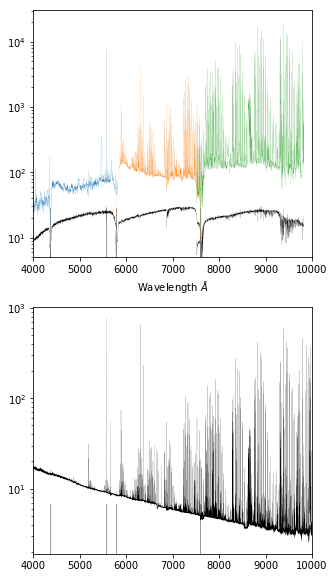

In [19]:
skyline_plot()

##  Zoom in on black line position: spurious BGS line fluxes. 

Line flux corresponds to 4359.6 Angstrom arc lamp line 

https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=2674;filename=CalibrationLamps.pdf;version=1

Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-b0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-r0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-z0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-b0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-r0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-z0-00052090.fits.


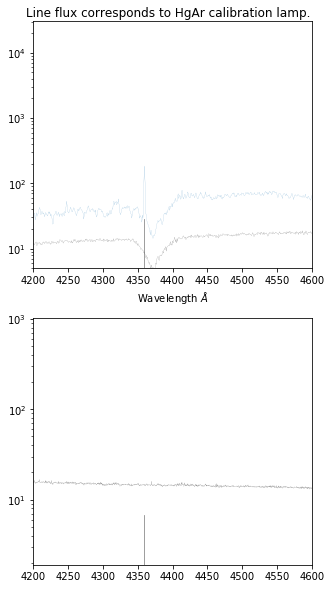

In [20]:
skyline_plot(4.2e3, 4.6e3, title='Line flux corresponds to HgAr calibration lamp.')

Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-b0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-r0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-z0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-b0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-r0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-z0-00052090.fits.


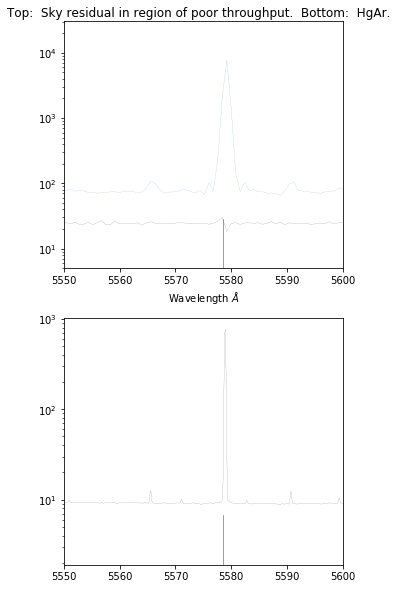

In [22]:
skyline_plot(5.55e3, 5.6e3, title='Top:  Sky residual in region of poor throughput.  Bottom:  HgAr.')

Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-b0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-r0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/sky-z0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-b0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-r0-00052090.fits.
Retrieving /global/projecta/projectdirs/desi/spectro/redux/minisv2/exposures/20200225//00052090/fluxcalib-z0-00052090.fits.


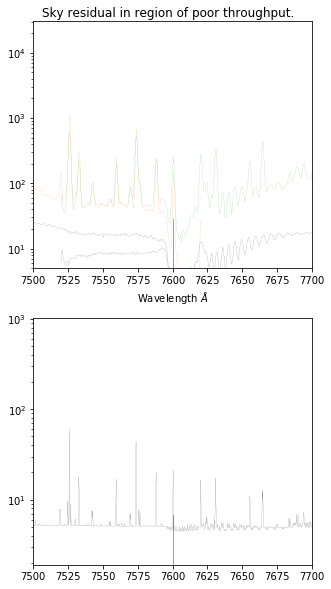

In [17]:
skyline_plot(7.5e3, 7.7e3, title='Sky residual in region of poor throughput.')

##  Done. 